In [16]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding
%matplotlib inline

In [17]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10):
        self.player_name = player_name
        self.card = []
        self.starter_balance = start_balance
        self.total_balance = start_balance

    def recharge_account(self):
        self.total_balance = self.starter_balance
        
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance))     

In [18]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def cmp(a, b):
    return float(a > b) - float(a < b)

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

In [19]:


class BlackjackEnv(gym.Env):
    """
    Simple blackjack environment
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation is: the players current sum, players current card, players balance left, 
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    Parameters
    ==========
    natural      boolean
                 option for 50% more reward on natural blackjack 
    
    """
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.total_players = 100
        self.players = {}
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}
        self.max_bet_cap = 10

    def add_player(self, player_class):
        if player_class not in self.players and len(self.players) < self.total_players:
            self.players[player_class.player_name] = player_class
            self.round_bet_info[player_class.player_name] = 0
#            print(player_class.player_name)
#            print(self.players)
        else:
            raise Exception("Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(len(self.players)))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, player_name, action):
#        print('Action : ',action)
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.players[player_name].card.append(draw_card(self.np_random))
            if is_bust(self.players[player_name].card):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.players[player_name].card), score(self.dealer))
            if self.natural and is_natural(self.players[player_name].card) and reward == 1:
                reward = 1.5
        if done:
            self.settle_balance(int(reward), player_name)
#        print('Ruhani: state : {}, reward : {}, is_round_done : {}'.format(self._get_obs(player_name),reward,done))
        return {'state':self._get_obs(player_name), 'reward': reward, 'is_round_done': done}

    def _get_obs(self, player_name):
        return {'player_info':self.get_player_obs(player_name), 
                'dealer_info': self.dealer[0]}

    def get_player_obs(self, player_name):
        return {'player_sum_card':sum_hand(self.players[player_name].card), 
                'player_card':self.players[player_name].card, 
                'player_total_balance':self.players[player_name].total_balance, 
                'usable_ace' : usable_ace(self.players[player_name].card)
               }
    
    def get_valid_bet_amount(self, player_name):
#        print("player name: {} money left: {}".format(player_name, self.players[player_name].total_balance))
        if self.players[player_name].total_balance < 1:
            return {'is_round_done': True, 'valid_bet_amount': -1}
        max_bet_upper_limit = self.players[player_name].total_balance
        if self.players[player_name].total_balance >= self.max_bet_cap:
            max_bet_upper_limit = self.max_bet_cap
        return {'is_round_done': False, 'valid_bet_amount': list(range(1, max_bet_upper_limit+1))}
            
    def init_round(self, player_name):         
        self.dealer = draw_hand(self.np_random)
        self.players[player_name].card = draw_hand(self.np_random)
        return {'state': self._get_obs(player_name)}        

    def bet_money(self, player_name, bet_amount):
        self.players[player_name].total_balance -= bet_amount
        self.round_bet_info[player_name] = bet_amount
            
    def settle_balance(self, is_winner, player_name):
#        print(self.players)
        if is_winner == 1:
#            print("player winner")
            self.players[player_name].total_balance += (2 * self.round_bet_info[player_name])
        elif is_winner == 0:
#            print("Draw match")
            self.players[player_name].total_balance += self.round_bet_info[player_name]
#        else:
#            print("player loser, wont get back the money, try next round")
    
    def reset(self, natural=False):
        for player_name, player_class in self.players.items():
            player_class.recharge_account()
        self.natural = natural
        self.dealer = []
        for player_name, player_class in self.players.items():
            self.round_bet_info [player_name]= 0

In [20]:
def get_state_from_observation(observation):
#    print(observation)
    player_sum_card = observation['player_info']['player_sum_card']
    dealer_info = observation['dealer_info']
    usable_ace = observation['player_info']['usable_ace']
#    print(observation)
    return '({},{},{})'.format(player_sum_card,dealer_info,usable_ace)

In [21]:
import random

class RLAgent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, num_episodes_to_train=30000):
        self.env = env

        self.valid_actions = list(range(self.env.action_space.n))

        self.Q = dict()          
        self.epsilon = epsilon   
        self.alpha = alpha      
        self.gamma = gamma      
        
        self.num_episodes_to_train = num_episodes_to_train
        self.small_decrement = (0.1 * epsilon) / (0.3 * num_episodes_to_train) 
        self.big_decrement = (0.8 * epsilon) / (0.4 * num_episodes_to_train)
        
        self.num_episodes_to_train_left = num_episodes_to_train

    def update_parameters(self):

        if self.num_episodes_to_train_left > 0.7 * self.num_episodes_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_episodes_to_train_left > 0.3 * self.num_episodes_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_episodes_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0

        self.num_episodes_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):

        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):

        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):

        self.create_Q_if_new_observation(observation)

        if random.random() > self.epsilon:
            maxQ = self.get_maxQ(observation)
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)

        self.update_parameters()

        return action


    def learn(self, observation, action, reward, next_observation):
        
#        print('{},{},{},{}'.format(observation, action, reward, next_observation))

        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])

Average payout after 1000 rounds after training for 100 episodes is -125.52


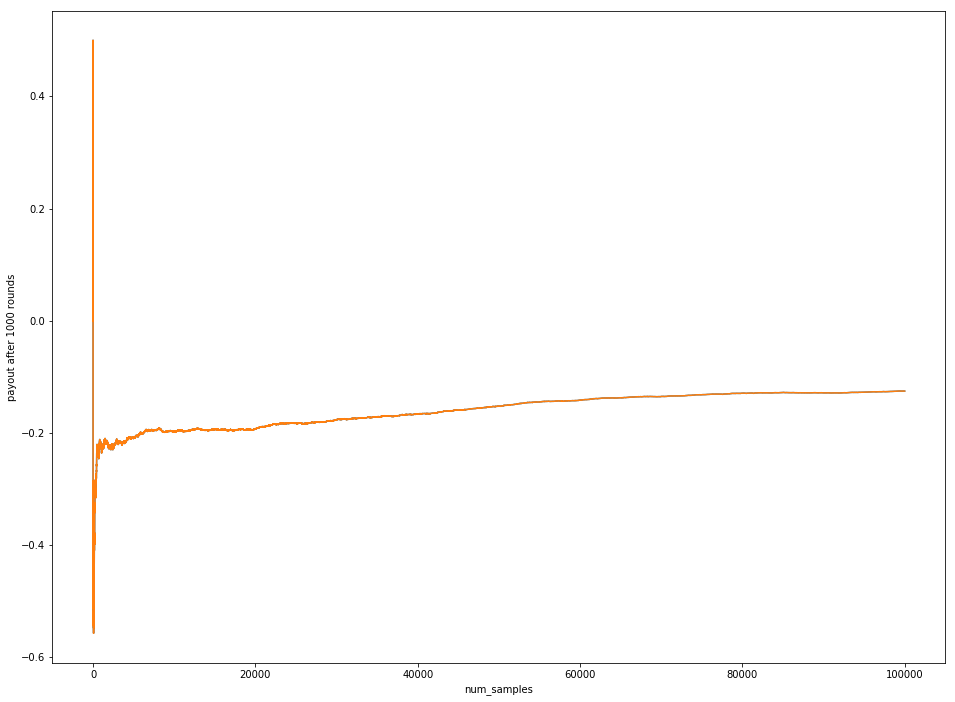

Average payout after 1000 rounds is -159.47277461036242


In [22]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = BlackjackEnv()
player1 = Player('ruhani')
env.add_player(player1)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples


num_episodes_values = range(200, 8000, 200)

plt.figure(num=None, figsize=(16, 12))
plt.clf()
                  
round_played = []
money_earned = []
total_payout = 0 # to store total payout over 'num_rounds'
average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
agent = RLAgent(env=env, epsilon=0.3, alpha=0.1, gamma=0.2, num_episodes_to_train=num_samples*num_rounds)


epsilon_values = []

for sample in range(num_samples):

    env.reset()
    for round in range (num_rounds):
        """
        valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
        if valid_bet_flag['is_round_done']:
#                print("You are out of money ! Will go to next game !!")
            break
        bet_amount = valid_bet_flag['valid_bet_amount']
        """

        observation = env.init_round(player1.player_name)
#        print('Observation : {}'.format(observation))
        observation = get_state_from_observation(env._get_obs(player1.player_name))
        # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0

#            involve_bet(env, player1, bet_amount)

        is_done = False
        while not is_done:
            if sample == 0:
                epsilon_values.append(agent.epsilon)
            action = agent.choose_action(observation)
#            print('Action : {}'.format(action))

            next_step = env.step(player1.player_name,action)
            next_observation = next_step['state']
            payout = next_step['reward']
            is_done = next_step['is_round_done']
#            print('Next Observation : {}'.format(env._get_obs(player1.player_name)))
            next_observation = get_state_from_observation(env._get_obs(player1.player_name))
            agent.learn(observation, action, payout, next_observation)
            total_payout += payout
            observation = next_observation

        average_payouts.append(total_payout/(sample*num_rounds + round+1))
#            average_payouts.append(total_payout/(num_samples))
    round_played.append(round+1)
    money_earned.append(env.players[player1.player_name].total_balance)
#        print('Round Played This Time : {}'.format(round+1))
plt.plot(average_payouts)
print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_samples, total_payout/num_samples))
plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))

In [23]:
def bet_money(agent, observation, max_bet_amt):

#    if max_bet_amt == 1:
#        bet_amt = 1
#    else:
    bet_strategy = agent.get_maxQ(observation)
    if bet_strategy > 1:
        pred = .5
    elif bet_strategy > 0.2:
        pred = .3
    elif bet_strategy > 0.1:
        pred = .2
    else:
        pred = 0.0
    bet_amt = int (max_bet_amt * pred)

    if (bet_amt == 0):
        bet_amt = 1
    
    print('Bet Amount : {}'.format(bet_amt))
    return bet_amt


In [26]:
import socket
import os
import subprocess
import ast
import numpy as np
player = 'Ruhani' #enter unique name for your game
s = socket.socket()
#host = 'localhost'
host = '10.216.25.34' # change ip addres to ip adress of your computer or use 'localhost' to practice
port = 9999

s.connect((host, port))

while True:
    data = s.recv(1024)
    if data.decode("utf-8") == 'send':
        s.send(str.encode( player))
        client_response = str(s.recv(20480), "utf-8")
        print(client_response, end="")
        break
while True:
    data = s.recv(1024)
    if data.decode("utf-8") == 'sendbet':
        ro=str(s.recv(20480), "utf-8")
        ro=ast.literal_eval(ro)
#        print(ro)
        
        player_state = ro['state']
        observation = get_state_from_observation(player_state)
        total_balance = ro['state']['player_info']['player_total_balance']
        print('Current Balance : {}'.format(total_balance))
# The above observation are stored in dict format. To access specific variables use syntax as 
# ro['state']['player_info']['player_total_balance']
# send whichever variable information stored in ro to your agent to help make the decision
#### Look at the above observations stored in variable ro as dictionary and store bet amount in variable bet#####
        bet=bet_money(agent, observation, total_balance)
        s.send(str.encode( str(bet)))
        
    if data.decode("utf-8") == 'sendaction':
        ro=str(s.recv(20480), "utf-8")
        ro=ast.literal_eval(ro)
#        print(ro)
        #follow same procedure as abov to send observations to your agent
        ###### Look at the above observations and action in variable action#####
        
#        action = np.random.randint(0, 2)
        player_state = ro['state']
        observation = get_state_from_observation(player_state)
        action = action = agent.choose_action(observation)
        print("action ",action)
        s.send(str.encode( str(action)))
    if data.decode("utf-8") == 'gameover':
        print("Game over wait for others to play and wait for results")
        
        
    

TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond